In [13]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
from aeon.datasets import load_classification
import numpy as np
import pandas as pd
import torch
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import collections
import os

import models.original_models as original_models
import models.models_3d_atomics_on_variate_to_concepts as new_models
from vasopressor.preprocess_helpers import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cuda')

In [14]:
X, y = load_classification("Tiselac", extract_path="/workdir/data")
print(" Shape of X = ", X.shape, type(X), X.dtype)
print(" Shape of y = ", y.shape, type(y), y.dtype)
y = y.astype(int)
display(y)


 Shape of X =  (99687, 10, 23) <class 'numpy.ndarray'> float64
 Shape of y =  (99687,) <class 'numpy.ndarray'> <U1


array([6, 1, 6, ..., 3, 4, 5])

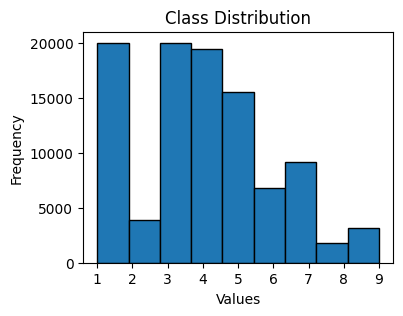

In [15]:
plt.figure(figsize=(4, 3))
plt.hist(y, bins=len(np.unique(y)), edgecolor='black')
plt.xticks(np.unique(y))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

In [16]:
def preprocess_data(_X, _y, batch_size = 4096, random_state = 1):    
    # swap T and V axis
    _X = _X.swapaxes(1,2)
    
    ## target
    _y = _y-1
    y_unique = np.unique(_y)
    num_classes = len(y_unique)
    
    # class weights
    weights = compute_class_weight(class_weight='balanced', classes=y_unique, y=_y)
    weights = torch.Tensor(weights).to(device)
    
    # split 60/20/20 %
    X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size = 0.40, random_state = random_state, stratify = _y)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.50, random_state = random_state, stratify = y_test)

    # normalize
    X_train, X_val, X_test = normalize_across_time(X_train, X_val, X_test)

    # tensor
    X_train_pt = torch.tensor(X_train)
    X_train_pt = add_indicators(X_train_pt)
    y_train_pt = torch.tensor(y_train)

    X_val_pt = torch.tensor(X_val)
    X_val_pt = add_indicators(X_val_pt)
    y_val_pt = torch.tensor(y_val)

    X_test_pt = torch.tensor(X_test)
    X_test_pt = add_indicators(X_test_pt)
    y_test_pt = torch.tensor(y_test)
    
    # dataloader
    train_dataset = TensorDataset(X_train_pt, y_train_pt)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=0, pin_memory=True)

    val_dataset = TensorDataset(X_val_pt, y_val_pt)
    val_loader = DataLoader(val_dataset, batch_size = X_val_pt.shape[0], shuffle=False, num_workers=0, pin_memory=True)

    test_dataset = TensorDataset(X_test_pt, y_test_pt)
    test_loader = DataLoader(test_dataset, batch_size = X_test_pt.shape[0], shuffle=False, num_workers=0, pin_memory=True)
    
    
    return train_loader, val_loader, test_loader, weights, num_classes


def add_indicators(data: torch.Tensor):
    indicators_3d = ~torch.isnan(data)
    data = torch.cat([data, indicators_3d], axis=-1) # (N x seq_len x 2*changing_dim)
    return data


def normalize_across_time(X_train, X_val, X_test):
    
    # scalerX=StandardScaler(with_std=False)
    scalerX=RobustScaler()
    n_variables = 10
    
    # N x T x V => N*T x V
    X_train_reshaped = X_train.reshape(-1, n_variables)
    X_val_reshaped = X_val.reshape(-1, n_variables)
    X_test_reshaped = X_test.reshape(-1, n_variables)

    nX_train = scalerX.fit_transform(X_train_reshaped)
    nX_val = scalerX.transform(X_val_reshaped)
    nX_test = scalerX.transform(X_test_reshaped)
    
    # revert shape
    nX_train = nX_train.reshape(X_train.shape)
    nX_val = nX_val.reshape(X_val.shape)
    nX_test = nX_test.reshape(X_test.shape)
    
    return nX_train, nX_val, nX_test


In [17]:
train_loader, val_loader, test_loader, weights, num_classes = preprocess_data(X,y)

for a,b in train_loader:
    print(a.shape)
    print(b.shape)
    break

len(train_loader)

torch.Size([4096, 23, 20])
torch.Size([4096])


15

In [34]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.legend()
    plt.show()

def plot_metrics(history, n_concepts_list):
    plt.plot(history[:, 0], history[:, 2], label=f'AUC')
    plt.plot(history[:, 0], history[:, 3], label=f'ACC')
    plt.plot(history[:, 0], history[:, 4], label=f'F1')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title('Plot of Concepts vs Criteria')
    plt.xticks(n_concepts_list)

    plt.legend()
    plt.show()



In [19]:
def initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim, top_k=''):
    model = original_models.CBM(input_dim = input_dim, 
                                changing_dim = changing_dim, 
                                seq_len = seq_len,
                                num_concepts = n_concepts,
                                opt_lr = 2e-4,
                                opt_weight_decay = 2e-05,
                                l1_lambda=0.001,
                                cos_sim_lambda=0.01,
                                output_dim = output_dim,
                                top_k=top_k,
                                device = device
                                )
    model = model.to(device)
    return model

def initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim, use_summaries_for_atomics, use_indicators, top_k=''):
    model = new_models.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            num_atomics= n_atomics,
                            use_summaries_for_atomics = use_summaries_for_atomics,
                            use_indicators = use_indicators,
                            opt_lr = 1e-3,
                            opt_weight_decay = 1e-4,
                            l1_lambda=1e-6,
                            cos_sim_lambda=1e-5,
                            output_dim = output_dim,
                            top_k=top_k,
                            device = device
                            )
    model = model.to(device)
    return model

In [20]:

auroc_metric = AUROC(task="multiclass", num_classes=num_classes).to(device)
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
f1_metric = F1Score(task="multiclass", num_classes=num_classes).to(device)
conf_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)

seq_len = X.shape[2]
changing_dim = X.shape[1]
input_dim = 2 * changing_dim

print(changing_dim, input_dim, seq_len)

random_seed = 1
set_seed(random_seed)


10 20 23


## Original

In [41]:
experiment_folder = "/workdir/optimal-summaries-public/_models/tiselac/original/"
model_path = experiment_folder + "tiselac_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [42]:
history_original = []

train_loader, val_loader, test_loader, weights, num_classes = preprocess_data(X, y)

n_concepts_list = list(range(5, 50, 5))

for n_concepts in n_concepts_list:
    print(n_concepts)
    
    model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes)
    model.fit(train_loader, val_loader, weights.to(device), model_path.format(n_concepts), 10000)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (Xb, yb) in enumerate(test_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            probs = model.forward_probabilities(Xb)
            
            auc = auroc_metric(probs, yb).item()
            acc = accuracy_metric(probs, yb).item()
            f1 = f1_metric(probs, yb).item()
            # conf_matrix(probs, yb)
        auc = auroc_metric.compute().item()
        acc = accuracy_metric.compute().item()
        f1 = f1_metric.compute().item()
        # conf_matrix.plot()
        # plt.show()
        auroc_metric.reset()
        accuracy_metric.reset()
        # conf_matrix.reset()
        f1_metric.reset()
    
    history = [n_concepts, model.val_losses[-1], auc, acc, f1]
    print(history)
    history_original.append(np.array(history))
    
    plot_losses(model.train_losses, model.val_losses)
    
history_original = np.array(history_original)
history_original.shape


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


5


  4%|▍         | 377/10000 [06:10<2:34:00,  1.04it/s]

In [ ]:
plot_metrics(history_original, n_concepts_list)


TypeError: list indices must be integers or slices, not tuple

## Atomics

In [ ]:
experiment_folder = "/workdir/optimal-summaries-public/_models/tiselac/atomics/"
model_path = experiment_folder + "tiselac_a{}_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [ ]:
history_atomics = []

train_loader, val_loader, test_loader, weights, num_classes = preprocess_data(X, y)

n_atomics_list = list(range(5, 50, 5))
n_concepts_list = list(range(5, 50, 5))

for n_atomics in n_atomics_list:
    for n_concepts in n_concepts_list:
        print(n_concepts)
        
        model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, num_classes, use_summaries_for_atomics=True, use_indicators=False)
        model.fit(train_loader, val_loader, p_weight=weights.to(device), save_model_path=model_path.format(n_atomics, n_concepts), max_epochs=10000)
        
        model.eval()
        with torch.no_grad():
            for batch_idx, (Xb, yb) in enumerate(test_loader):
                Xb, yb = Xb.to(device), yb.to(device)
                probs = model.forward_probabilities(Xb)
                
                auc = auroc_metric(probs, yb).item()
                acc = accuracy_metric(probs, yb).item()
                f1 = f1_metric(probs, yb).item()
                # conf_matrix(probs, yb)
            auc = auroc_metric.compute().item()
            acc = accuracy_metric.compute().item()
            f1 = f1_metric.compute().item()
            # conf_matrix.plot()
            # plt.show()
            auroc_metric.reset()
            accuracy_metric.reset()
            # conf_matrix.reset()
            f1_metric.reset()
        
        history = [n_atomics, n_concepts, model.val_losses[-1], auc, acc, f1]
        print(history)
        history_atomics.append(np.array(history))
        
        # plot_losses(model.train_losses, model.val_losses)
    
history_atomics = np.array(history_atomics)
history_atomics.shape


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


5


  0%|          | 0/10000 [00:00<?, ? epoch/s]


RuntimeError: mat1 and mat2 must have the same dtype

In [ ]:
plot_metrics(history_atomics, n_concepts_list)


## Optimization

In [ ]:
# feature weights
n_concepts = 4

model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes)
model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

for batch_idx, (Xb, yb) in enumerate(test_loader):
    Xb, yb = Xb.to(device), yb.to(device)
    probs = model.forward_probabilities(Xb)
    
    auc = auroc_metric(probs, yb).item()
    acc = accuracy_metric(probs, yb).item()
    conf_matrix(probs, yb)
auc = auroc_metric.compute().item()
acc = accuracy_metric.compute().item()
conf_matrix.plot()
auroc_metric.reset()
accuracy_metric.reset()
conf_matrix.reset()

print("AUC", auc)
print("ACC", acc)

In [ ]:
for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

In [ ]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


In [ ]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

In [ ]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
V = 13 + 1
T = seq_len + 1
print(T)
vars_ = [i for i in range(1,V)] + [str(i) + "_ind" for i in range(1,V)]
print(len(vars_))
data_cols = [["feat_{}_time_{}".format(v, t) for v in vars_] for t in range(1, T)]
flattened_data_cols = [col for sublist in data_cols for col in sublist]
print(len(flattened_data_cols))
flattened_data_cols

In [ ]:

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


In [ ]:
greedy_results = greedy_selection(auroc_metric, test_loader, top_k_inds, model, track_metrics={"acc": accuracy_metric})
greedy_results.head(10)

In [ ]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results.columns)
    # writing the data rows 
    for row in greedy_results.itertuples(index=False):
        csvwriter.writerow(list(row))


In [ ]:
sorted_ = greedy_results.sort_values(["Concept", "ID"])

for row in sorted_.itertuples(index=False):
    name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, row[1])
    print(f"Concept {row[2]}: ID {row[1]}, Feature {name}, Summary {summary}")

In [ ]:
plt.plot(greedy_results["Score"], label = f"AUC {greedy_results['Score'].values[-1]:.3f}")
plt.plot(greedy_results["acc"], label = f"ACC {greedy_results['acc'].values[-1]:.3f}")

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')

plt.legend()
plt.show()


In [ ]:
top_k_csv_file = "/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/bottleneck_r1_c6_topkinds.csv"
n_concepts = 6
model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes, top_k=top_k_csv_file)
# model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()

print(auc)
print(acc)


In [ ]:
model.fit(train_loader, val_loader, weights, save_model_path="/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/arabic_c6_finetuned.pt", max_epochs=3000, patience=100)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb)
        acc = accuracy_metric(probs, yb)
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
print(auc)
print(acc)


In [ ]:

plt.plot(model.val_losses)
plt.show()